In [1]:
import numpy as np
from scipy.linalg import toeplitz
from skimage.draw import line_aa
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=300

## Pupil Function

In [3]:
def create_angle_slit(h, w, slit_width, damp, r0=None, r1=None, flip=None):
    first_row = np.array([True]*slit_width + [False]*(w - slit_width))
    first_col = np.array([True] + [False]*(h-1))
    full_slit = toeplitz(first_col, first_row)
    
    mask = create_circular_mask(h, w, radius=(w - damp)/2)
    slit = full_slit * mask
    
    if flip:
        slit = np.flip(slit, axis=1)
    if r0:
        slit = np.roll(slit, r0, axis=0)
    if r1:
        slit = np.roll(slit, r1, axis=1)
    
    return slit

def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [4]:
# References:
# https://github1s.com/greje656/PhysicallyBasedLensFlare/blob/master/Lens/starburst.hlsl
# http://kmdouglass.github.io/posts/simple-pupil-function-calculations/
def create_dirty_mask(size):
    dirty_mask = np.zeros(shape=(size, size), dtype=bool)

    num_dots = round(np.random.normal(size / 7, size / 30))
    max_dot_radius = round(np.random.normal(size / 45, size / 100))

    # add dot masks
    for i in range(num_dots):
        x = round(np.random.uniform(0, dirty_mask.shape[1]))
        y = round(np.random.uniform(0, dirty_mask.shape[0]))
        r = round(np.random.uniform(0, max_dot_radius))

        dot = create_circular_mask(size, size, radius=r, center=(x, y))
        dirty_mask += dot

    num_slits = round(np.random.normal(size / 25, size / 90))
    max_slit_length = round(np.random.normal(size / 6, size / 90))
    
    # add slit masks
    for i in range(num_slits):
#         r0 = round(np.random.uniform(-size / 2, size / 2))
#         r1 = round(np.random.uniform(-size / 2, size / 2))
#         flip = np.random.choice([False, True])
#         length = round(np.random.uniform(size / 2, size / 1.2))

#         slit = create_angle_slit(size, size, 2, length, r0=r0, r1=r1, flip=flip)
#         dirty_mask += slit

        while True:
            # row
            r0 = round(np.random.uniform(0, size))
            r1 = round(np.random.uniform(0, size))
            # col
            c0 = round(np.random.uniform(0, size))
            c1 = round(np.random.uniform(0, size))
            
            if ((r0 - r1)**2 + (c0 - c1)**2) ** 0.5 <= max_slit_length:
                rr, cc, val = line_aa(r0, c0, r1, c1)
                dirty_mask[rr, cc] = True
                break

    return dirty_mask

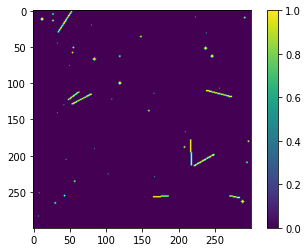

In [5]:
aperture_function = create_dirty_mask(IMAGE_SIZE)
plt.imshow(aperture_function.astype(np.uint8))
plt.colorbar()

In [6]:
def get_normalized_fourier(matrix):
    fourier = np.abs(np.fft.fft2(matrix))
    shifted_fourier = np.fft.fftshift(fourier) ** 0.7
    row_sums = shifted_fourier.sum(axis=1)
    normalized_fourier = shifted_fourier / row_sums[:, np.newaxis]
    
    return normalized_fourier

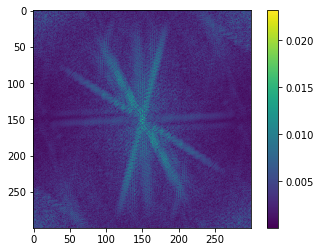

In [7]:
fourier = get_normalized_fourier(aperture_function.astype(float))

plt.imshow(fourier)
plt.colorbar()

In [8]:
origin = (200, 100)
depth = 300

def create_phase_matrix(size, lr_shift, ud_shift):
    k = np.arange(-size//2, size//2) * (1.0 / size)
    kx, ky = np.meshgrid(k, k)

    return np.exp(1j * 2 * np.pi * (kx * lr_shift + ky * ud_shift)).astype('complex')
    

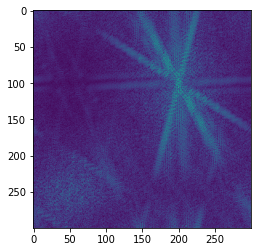

In [23]:
shift_right = 50
shift_down = -50

phase = create_phase_matrix(IMAGE_SIZE, shift_right, shift_down)
pupil_func = aperture_function.astype(np.complex64) * phase

shifted_fourier = get_normalized_fourier(pupil_func)
plt.imshow(shifted_fourier)

## Spectral Response Function

In [45]:
# https://github1s.com/greje656/PhysicallyBasedLensFlare/blob/master/Lens/starburst.hlsl
# wavelength to rgb
def wl2rgbTannenbaum(w):
    r = []

    if w < 350.0:
        r = [0.5, 0.0, 1.0]
    elif w >= 350.0 and w < 440.0:
        r = [440.0 - w / 90.0, 0.0, 1.0]
    elif w >= 440.0 and w <= 490.0:
        r = [0.0, w - 440.0 / 50.0, 1.0]
    elif w >= 490.0 and w < 510.0:
        r = [0.0, 1.0, -(w - 510.0) / 20.0]
    elif w >= 510.0 and w < 580.0:
        r = [w - 510.0 / 70.0, 1.0, 0.0]
    elif w >= 580.0 and w < 645.0:
        r = [1.0, -(w - 645.0) / 65.0, 0.0]
    else:
        r = [1.0, 0.0, 0.0]

    if w < 350.0:
        r *= 0.3
    elif w >= 350.0 and w < 420.0:
        r *= 0.3 + 0.7 * (w - 350.0 / 70.0)
    elif w >= 420.0 and w <= 700.0:
        r *= 1.0
    elif w > 700.0 and w <= 780.0:
        r *= 0.3 + 0.7 * (780.0 - w / 80.0)
    else:
        r *= 0.3

    return r

In [41]:
from scipy.stats import norm

In [25]:
wavelengths = np.arange(380, 745, 5)

In [26]:
mu_R = np.random.uniform(620, 640, 1)
mu_G = np.random.uniform(540, 560, 1)
mu_B = np.random.uniform(460, 480, 1)

sigma_R = np.random.uniform(50, 60, 1)
sigma_G = np.random.uniform(50, 60, 1)
sigma_B = np.random.uniform(50, 60, 1)

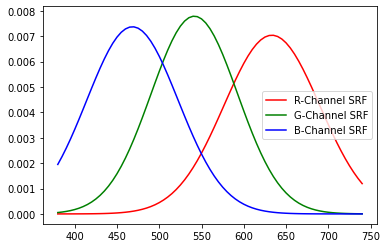

In [27]:
# Example SRF
plt.plot(wavelengths, norm.pdf(wavelengths, mu_R, sigma_R), color='r', label='R-Channel SRF')
plt.plot(wavelengths, norm.pdf(wavelengths, mu_G, sigma_G), color='g', label='G-Channel SRF')
plt.plot(wavelengths, norm.pdf(wavelengths, mu_B, sigma_B), color='b', label='B-Channel SRF')
plt.legend()

In [28]:
SRF_R = norm.pdf(wavelengths, mu_R, sigma_R)[None, :]
SRF_G = norm.pdf(wavelengths, mu_G, sigma_G)[None, :]
SRF_B = norm.pdf(wavelengths, mu_B, sigma_B)[None, :]

In [29]:
SRF = np.concatenate((SRF_R, SRF_G, SRF_B), axis=0)
SRF.shape

(3, 73)

## Combining

In [78]:
psf = np.repeat(np.expand_dims(shifted_fourier, axis=0), 73, axis=0)
psf = psf.reshape(73, -1)

In [79]:
psf.shape

(73, 90000)

In [80]:
psf_rgb = (SRF @ psf)

In [81]:
psf_rgb = psf_rgb.reshape(3, IMAGE_SIZE, IMAGE_SIZE)

In [88]:
psf_rgb = psf_rgb / np.max(psf_rgb)

In [89]:
transposed_psf_rgb = np.transpose(psf_rgb, (1, 2, 0))

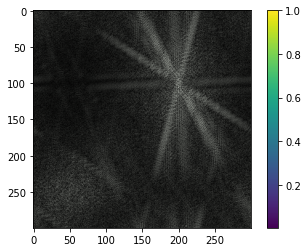

In [90]:
plt.imshow(transposed_psf_rgb)
plt.colorbar()